<a href="https://colab.research.google.com/github/arisviel/Segmentation/blob/master/Copy_of_Copy_of_Extra_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import torch
import copy
import time
import os
import cv2
import torchvision.transforms.functional as TF
import random

from tqdm import tqdm
from torchvision import models
from torchvision import transforms
from sklearn.metrics import roc_auc_score, f1_score
from torch import nn
from PIL import Image

from matplotlib import pyplot as plt

SEED=np.random.seed(42)

Запишем функцию декодера масок, которая считывает второй столбец в файле и из числовой последовательности создает тензор-маску

In [0]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

Посмотрим на данные, и разобъем выборку на трейн и тест

In [8]:
data_list=pd.read_csv('/content/drive/My Drive/train_masks.csv/train_masks.csv')
print(data_list.head(), '\n', data_list.shape)

                   img                                           rle_mask
0  00087a6bd4dc_01.jpg  879386 40 881253 141 883140 205 885009 17 8850...
1  00087a6bd4dc_02.jpg  873779 4 875695 7 877612 9 879528 12 881267 15...
2  00087a6bd4dc_03.jpg  864300 9 866217 13 868134 15 870051 16 871969 ...
3  00087a6bd4dc_04.jpg  879735 20 881650 26 883315 92 883564 30 885208...
4  00087a6bd4dc_05.jpg  883365 74 883638 28 885262 119 885550 34 88716... 
 (5088, 2)


In [0]:
data_train=data_list[:4000]
data_test=data_list[4000:]

In [0]:
def batch_generator(phase,data_tr,data_val,batch_size=10,num_batches=100):
    if phase == 'train':
        data = data_tr
    else:
        data = data_val
    #перемешаем список пикч
    train_list = (data.iloc[np.random.permutation(len(data))]).reset_index(drop=True)
    train_list = (train_list.iloc[np.random.permutation(len(data))]).reset_index(drop=True)
    
    for batch in range(num_batches):
        for size in range(batch_size):

            index = batch * batch_size + size #текущий индекс
            imag, mask_rle = train_list.iloc[index] #считываем информацию

            #считываем изображение, декодим маску
            image = Image.open('/content/drive/My Drive/train/'+ imag)
            mask_rle = rle_decode(mask_rle)
            mask_rle = mask_rle*255
            #mask=np.concatenate((mask_rle,mask_rle,mask_rle), axis = 2)

            topil=transforms.ToPILImage()
            mask= topil(mask_rle)

            # Resize
            resize = transforms.Resize(size=(250, 250))
            image = resize(image)
            mask = resize(mask)

            if phase == 'train':
              # Random crop
              i, j, h, w = transforms.RandomCrop.get_params(
                  image, output_size=(226, 226))
              image = TF.crop(image, i, j, h, w)
              mask = TF.crop(mask, i, j, h, w)

              # Random horizontal flipping
              if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

              # Random vertical flipping
              if random.random() > 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

            else:
              CentralCrop = transforms.CenterCrop(226)
              image = CentralCrop(image)
              mask = CentralCrop(mask)


            #tr_im = transforms.Compose([transforms.ToFloatTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      #])
            
            #tr_m = transforms.Compose([transforms.ToFloatTensor(),
                                      #transforms.Normalize([0.499], [0.226])
                                      #])


            # Transform to tensor
            image = TF.to_tensor(image)
            mask= TF.to_tensor(mask)
            #mask = (torch.from_numpy(np.array(mask))).float()
            #mask = mask.unsqueeze(0)
            tr_im = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
            #tr_m=transforms.Normalize(mean=[0.449],std=[0.226])
            image = tr_im(image)
            #mask = tr_m(mask)
            
            image = (image).unsqueeze(0)
            
            mask = mask.unsqueeze(0)
            if size == 0: #стакаем батчи по 0 оси
                x_batch = image
                y_batch = mask
            else:
                x_batch = torch.cat((x_batch, image),0)
                y_batch = torch.cat((y_batch, mask),0)

            yield x_batch, y_batch


In [11]:
for x,y in batch_generator('val',data_train,data_test, batch_size=4, num_batches=1):
  test=1
y.shape

torch.Size([4, 1, 226, 226])

In [0]:
np.unique(y)

In [0]:
y.shape

torch.Size([4, 1, 226, 226])

In [0]:
np.unique(y)

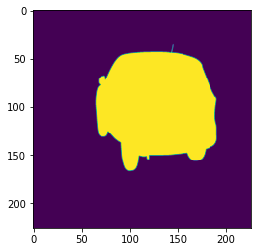

In [12]:
plt.imshow((y[1,:].permute(1,2,0).numpy())[...,0])

In [0]:
def train_model(model, criterion, optimizer, data_tr, data_val, num_epochs=3, batch_size=20,num_batches=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_acc = 0.0
    val_acc_history = []
    val_loss_history =[]
    # Initialize the log file for training and testing loss and metrics
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataset_sizes = batch_size*num_batches
            else:
                model.eval()   # Set model to evaluate mode
                dataset_sizes = batch_size*num_batches

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in batch_generator(phase, data_tr, data_val, batch_size,num_batches):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    #outputs = model(inputs)['out']
                   
                    #loss = criterion(outputs, labels)
                    out=model(inputs)
                    outputs = out['out']
                    aux_outputs = out['aux']


                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

In [0]:
class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
            #nn.Sigmoid() #Добавим активацию - сигмоиду
        )

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)

class ASPPConv2(nn.Sequential): #Бывший слой адаптивного пулинга, просто вырезал его, сделав обычный конв слой 🤷‍♀️🤷‍♀️🤷‍♀️
    def __init__(self, in_channels, out_channels,):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv2, self).__init__(*modules)



class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rate1, rate2, rate3 = tuple(atrous_rates)
        modules.append(ASPPConv(in_channels, out_channels, rate1))
        modules.append(ASPPConv(in_channels, out_channels, rate2))
        modules.append(ASPPConv(in_channels, out_channels, rate3))
        modules.append(ASPPConv2(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(5 * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))
    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)


In [0]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, 1)
    # Set the model in training mode
    model.train()
    return model

In [16]:
model=createDeepLabv3().cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [0]:
model

In [0]:
#model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True).cuda().eval()

In [0]:
conv=torch.nn.Conv2d(
    in_channels=256,
    out_channels=1,
    kernel_size=(1, 1),
    stride=(1, 1)
).cuda()
t=torch.nn.Sigmoid()
model.aux_classifier[4]=conv
#model.aux_classifier=nn.Sequential(*list(model.aux_classifier)+[t])

In [0]:
# Specify the loss function
criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(modelf.,)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
                             #)
# Specify the optimWizer with a lower learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4yyiios)

In [20]:
trained_mode,acc,lss = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=20, batch_size=4,num_batches=70)

Epoch 1/20
----------
train Loss: 0.3003 Acc: 281675.7893
val Loss: 0.1813 Acc: 281091.0750

Epoch 2/20
----------
train Loss: 0.1398 Acc: 282143.4143
val Loss: 0.1307 Acc: 278297.2964

Epoch 3/20
----------
train Loss: 0.1099 Acc: 279419.7679
val Loss: 0.0943 Acc: 279393.7250

Epoch 4/20
----------
train Loss: 0.0877 Acc: 281631.3750
val Loss: 0.0821 Acc: 280118.4750

Epoch 5/20
----------
train Loss: 0.0791 Acc: 281421.0143
val Loss: 0.0742 Acc: 280545.1500

Epoch 6/20
----------
train Loss: 0.0714 Acc: 281293.2857
val Loss: 0.0913 Acc: 278554.8536

Epoch 7/20
----------
train Loss: 0.0720 Acc: 280936.3679
val Loss: 0.0742 Acc: 278248.3964

Epoch 8/20
----------
train Loss: 0.0693 Acc: 280939.4786
val Loss: 0.0742 Acc: 277297.1714

Epoch 9/20
----------
train Loss: 0.0659 Acc: 283688.3286
val Loss: 0.0690 Acc: 278550.8536

Epoch 10/20
----------
train Loss: 0.0645 Acc: 280318.5714
val Loss: 0.0668 Acc: 279530.1679

Epoch 11/20
----------
train Loss: 0.0644 Acc: 280327.7571
val Loss: 

In [68]:
trained_model,acc2,lss2 = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=20, batch_size=4,num_batches=70)

Epoch 1/20
----------
train Loss: 0.0572 Acc: 280531.6643
val Loss: 0.0602 Acc: 281100.9357

Epoch 2/20
----------
train Loss: 0.0547 Acc: 281094.4214
val Loss: 0.0603 Acc: 280147.5464

Epoch 3/20
----------
train Loss: 0.0682 Acc: 282084.5357
val Loss: 0.0707 Acc: 281744.9893

Epoch 4/20
----------
train Loss: 0.0625 Acc: 283049.9821
val Loss: 0.0722 Acc: 278998.0214

Epoch 5/20
----------
train Loss: 0.0609 Acc: 281175.8857
val Loss: 0.0624 Acc: 278332.7607

Epoch 6/20
----------
train Loss: 0.0695 Acc: 279638.4643
val Loss: 0.0655 Acc: 278806.3857

Epoch 7/20
----------
train Loss: 0.0587 Acc: 280807.6857
val Loss: 0.0608 Acc: 278456.5286

Epoch 8/20
----------
train Loss: 0.0560 Acc: 281707.0214
val Loss: 0.0569 Acc: 279158.8429

Epoch 9/20
----------
train Loss: 0.0549 Acc: 280670.1429
val Loss: 0.0584 Acc: 279226.7750

Epoch 10/20
----------
train Loss: 0.0547 Acc: 279140.1250
val Loss: 0.0563 Acc: 279691.7071

Epoch 11/20
----------
train Loss: 0.0567 Acc: 280971.6107
val Loss: 

In [75]:
trained_model3,acc3,lss3 = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=20, batch_size=4,num_batches=250)

Epoch 1/20
----------
train Loss: 0.0721 Acc: 280848.2620
val Loss: 0.0615 Acc: 279432.5350

Epoch 2/20
----------
train Loss: 0.0564 Acc: 281687.4920
val Loss: 0.0612 Acc: 278930.0430

Epoch 3/20
----------
train Loss: 0.0557 Acc: 280730.0400
val Loss: 0.0586 Acc: 279829.6020

Epoch 4/20
----------
train Loss: 0.0542 Acc: 281327.7730
val Loss: 0.0584 Acc: 279673.3630

Epoch 5/20
----------
train Loss: 0.0547 Acc: 280718.9990
val Loss: 0.0555 Acc: 279776.7170

Epoch 6/20
----------
train Loss: 0.0538 Acc: 282006.5550
val Loss: 0.0558 Acc: 279288.4300

Epoch 7/20
----------
train Loss: 0.0536 Acc: 281091.5560
val Loss: 0.0561 Acc: 279512.7730

Epoch 8/20
----------
train Loss: 0.0530 Acc: 280884.9270
val Loss: 0.0567 Acc: 279155.7240

Epoch 9/20
----------
train Loss: 0.0523 Acc: 281471.3300
val Loss: 0.0544 Acc: 279513.3450

Epoch 10/20
----------
train Loss: 0.0515 Acc: 281654.6690
val Loss: 0.0547 Acc: 279894.9900

Epoch 11/20
----------
train Loss: 0.0526 Acc: 280574.6300
val Loss: 

In [0]:
# Specify the loss function
criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(modelf.,)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [131]:
trained_model3,acc3,lss3 = train_model(model, criterion, optimizer, data_train,data_test, num_epochs=10, batch_size=4,num_batches=250)

Epoch 1/10
----------
train Loss: 0.0493 Acc: 280729.2080
val Loss: 0.0502 Acc: 278977.1350

Epoch 2/10
----------
train Loss: 0.0490 Acc: 279643.0700
val Loss: 0.0491 Acc: 279603.9780

Epoch 3/10
----------
train Loss: 0.0476 Acc: 280947.7200
val Loss: 0.0492 Acc: 280174.1960

Epoch 4/10
----------
train Loss: 0.0477 Acc: 281139.3150
val Loss: 0.0496 Acc: 279431.6960

Epoch 5/10
----------
train Loss: 0.0469 Acc: 280836.2090
val Loss: 0.0491 Acc: 279630.3680

Epoch 6/10
----------
train Loss: 0.0477 Acc: 279760.7920
val Loss: 0.0485 Acc: 279810.6360

Epoch 7/10
----------
train Loss: 0.0477 Acc: 280240.4110
val Loss: 0.0487 Acc: 279212.7390

Epoch 8/10
----------
train Loss: 0.0466 Acc: 281246.5340
val Loss: 0.0485 Acc: 279348.7320

Epoch 9/10
----------
train Loss: 0.0457 Acc: 281926.1870
val Loss: 0.0484 Acc: 280051.4890

Epoch 10/10
----------
train Loss: 0.0463 Acc: 281165.9650
val Loss: 0.0485 Acc: 279638.1120

Training complete in 89m 15s
Best val loss: 0.048394
Best val Acc: 28

In [0]:
def test_model(model, number=0, way='/content/drive/My Drive/test/'):
    data=pd.read_csv('/content/drive/My Drive/test/test.csv')
    img_name = data.iloc[number,0]
    
    

    imagea = Image.open(way + img_name)
    h,w,c=np.array(imagea).shape
            # Resize
    resize = transforms.Resize(size=(250, 250))
    imager = resize(imagea)
    
    #CentralCrop = transforms.CenterCrop(512)
    #image = CentralCrop(image)
   # Transform to tensor
    #image = TF.to_tensor(image)

    #tr = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

    #image = tr(image)

    trf = transforms.Compose([#transforms.Resize(250),
                 #transforms.CenterCrop(224),
                 transforms.ToTensor(), 
                 transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
    
  
    image= trf(imager)
    image = image.unsqueeze(0).cuda()
    model.eval()
    mas = model(image)['out']
    #msa = model(image)
    
    masks = mas.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    masks = 1/(1 + np.exp(-masks)) 
    mask = cv2.resize(masks,(w,h))
    imager = cv2.resize(np.array(imager), (w, h))
    
    fig, axs = plt.subplots(1, 3, figsize=(25,5))

    #plot the original data
    axs[0].imshow(imagea,aspect=1) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow((mask>0.5),aspect=1)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(imager)
    axs[2].imshow((mask>0.5), alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    #plt.suptitle('Image with mask')
    return mas,mask #plt.show()

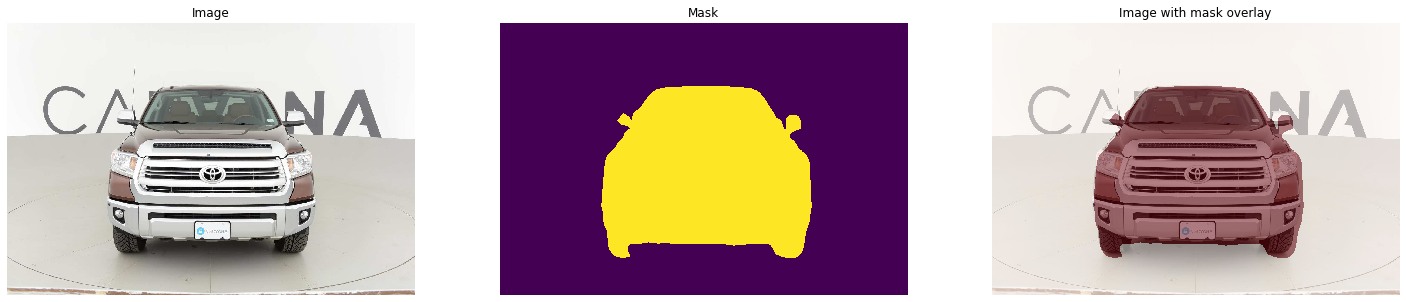

In [67]:
mask,mm = test_model(model,number=0)

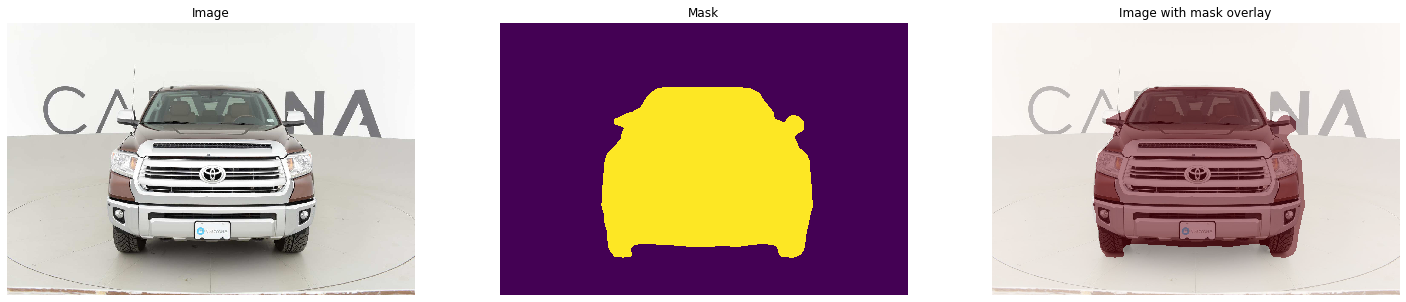

In [74]:
mask,mm = test_model(model,number=0)

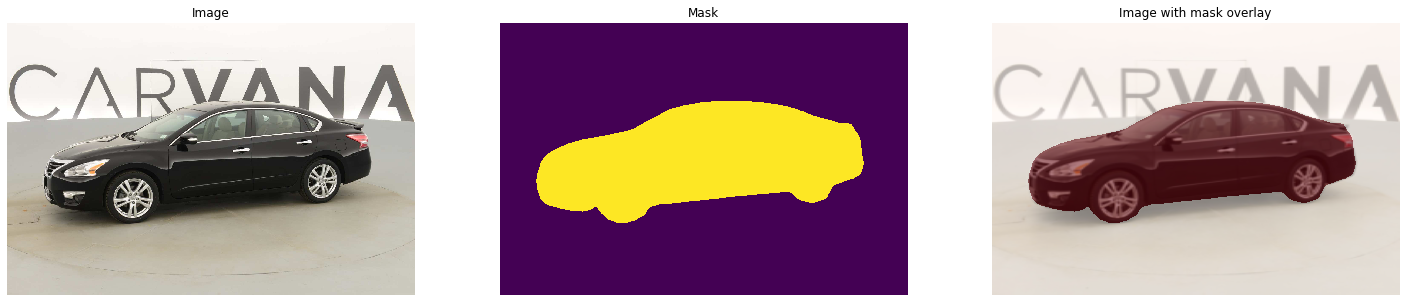

In [129]:
mask,mm = test_model(model,number=19)

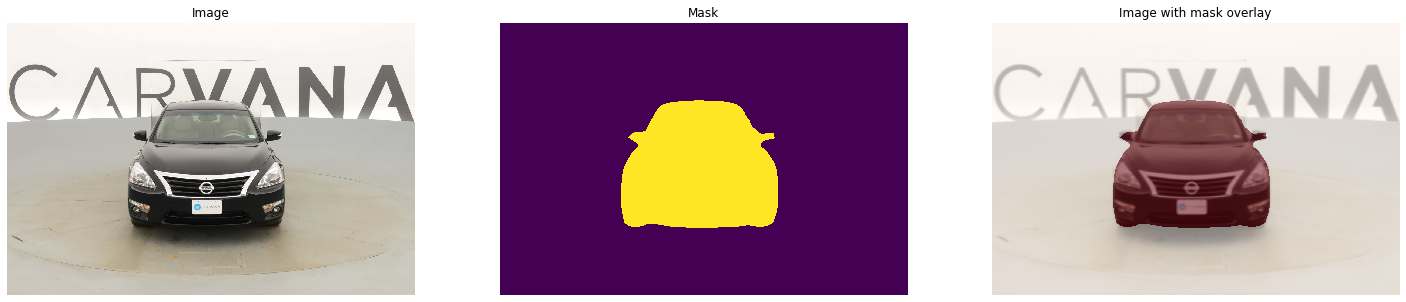

In [122]:
mask,mm = test_model(model,number=16)

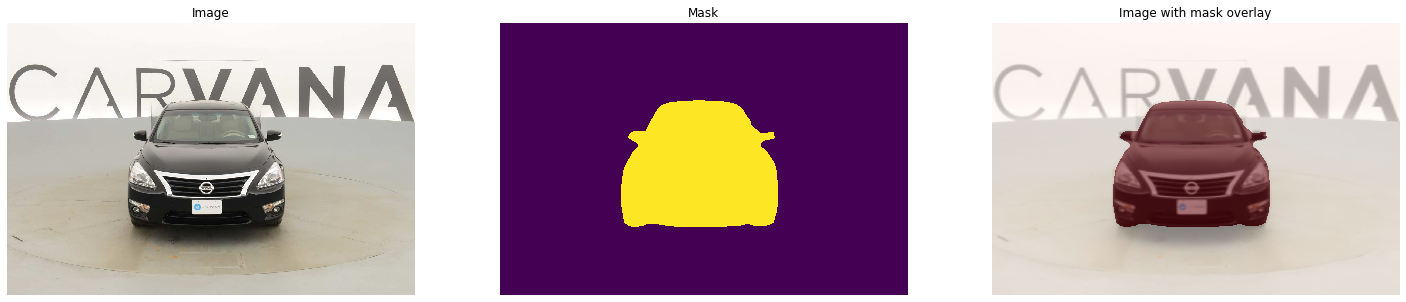

In [132]:
mask,mm = test_model(model,number=16)

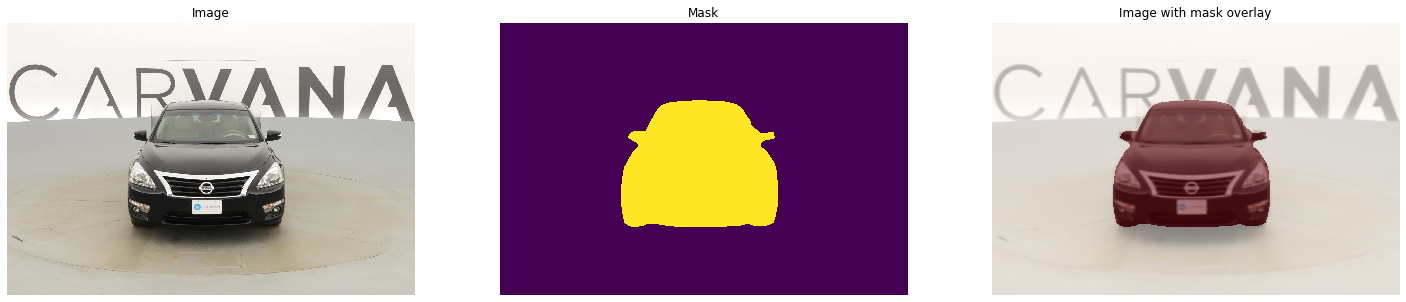

In [165]:
mask,mm = test_model(model,number=16)

In [110]:
acc

[tensor(281091.0750, device='cuda:0', dtype=torch.float64),
 tensor(278297.2964, device='cuda:0', dtype=torch.float64),
 tensor(279393.7250, device='cuda:0', dtype=torch.float64),
 tensor(280118.4750, device='cuda:0', dtype=torch.float64),
 tensor(280545.1500, device='cuda:0', dtype=torch.float64),
 tensor(278554.8536, device='cuda:0', dtype=torch.float64),
 tensor(278248.3964, device='cuda:0', dtype=torch.float64),
 tensor(277297.1714, device='cuda:0', dtype=torch.float64),
 tensor(278550.8536, device='cuda:0', dtype=torch.float64),
 tensor(279530.1679, device='cuda:0', dtype=torch.float64),
 tensor(277637.9607, device='cuda:0', dtype=torch.float64),
 tensor(279771.5679, device='cuda:0', dtype=torch.float64),
 tensor(278943.1964, device='cuda:0', dtype=torch.float64),
 tensor(282087.6071, device='cuda:0', dtype=torch.float64),
 tensor(278359.3893, device='cuda:0', dtype=torch.float64),
 tensor(279696.6607, device='cuda:0', dtype=torch.float64),
 tensor(280708.1714, device='cuda:0', dt

In [111]:
acc2

[tensor(281100.9357, device='cuda:0', dtype=torch.float64),
 tensor(280147.5464, device='cuda:0', dtype=torch.float64),
 tensor(281744.9893, device='cuda:0', dtype=torch.float64),
 tensor(278998.0214, device='cuda:0', dtype=torch.float64),
 tensor(278332.7607, device='cuda:0', dtype=torch.float64),
 tensor(278806.3857, device='cuda:0', dtype=torch.float64),
 tensor(278456.5286, device='cuda:0', dtype=torch.float64),
 tensor(279158.8429, device='cuda:0', dtype=torch.float64),
 tensor(279226.7750, device='cuda:0', dtype=torch.float64),
 tensor(279691.7071, device='cuda:0', dtype=torch.float64),
 tensor(278485.8393, device='cuda:0', dtype=torch.float64),
 tensor(278977.9000, device='cuda:0', dtype=torch.float64),
 tensor(278795.5179, device='cuda:0', dtype=torch.float64),
 tensor(279496.5607, device='cuda:0', dtype=torch.float64),
 tensor(278794.4643, device='cuda:0', dtype=torch.float64),
 tensor(279285.0321, device='cuda:0', dtype=torch.float64),
 tensor(281106.6821, device='cuda:0', dt

In [112]:
acc3

[tensor(279432.5350, device='cuda:0', dtype=torch.float64),
 tensor(278930.0430, device='cuda:0', dtype=torch.float64),
 tensor(279829.6020, device='cuda:0', dtype=torch.float64),
 tensor(279673.3630, device='cuda:0', dtype=torch.float64),
 tensor(279776.7170, device='cuda:0', dtype=torch.float64),
 tensor(279288.4300, device='cuda:0', dtype=torch.float64),
 tensor(279512.7730, device='cuda:0', dtype=torch.float64),
 tensor(279155.7240, device='cuda:0', dtype=torch.float64),
 tensor(279513.3450, device='cuda:0', dtype=torch.float64),
 tensor(279894.9900, device='cuda:0', dtype=torch.float64),
 tensor(279526.3410, device='cuda:0', dtype=torch.float64),
 tensor(279362.7980, device='cuda:0', dtype=torch.float64),
 tensor(279657.5610, device='cuda:0', dtype=torch.float64),
 tensor(279162.7240, device='cuda:0', dtype=torch.float64),
 tensor(279395.4520, device='cuda:0', dtype=torch.float64),
 tensor(279567.7950, device='cuda:0', dtype=torch.float64),
 tensor(279778.4500, device='cuda:0', dt

In [113]:
lss

[0.1812561190421028,
 0.13067765199978437,
 0.09429620087945036,
 0.08205000539310277,
 0.07415917779851172,
 0.0913409585199718,
 0.07422155554273299,
 0.07418746985495091,
 0.06903271740302444,
 0.06680643608394478,
 0.06806656141499323,
 0.07557918379482415,
 0.07096599001171333,
 0.17081062554913973,
 0.08078732070779161,
 0.08614245146912124,
 0.06552349461375602,
 0.06337938564164299,
 0.06412536294997803,
 0.06262423229137702]

In [114]:
lss2

[0.06015571882349572,
 0.06026389488085572,
 0.07069191856841955,
 0.07217965935623007,
 0.06244526696724019,
 0.06551336813052851,
 0.06076028185031776,
 0.05690245611726173,
 0.058351882859798414,
 0.05629195269928979,
 0.05789726138048406,
 0.0574928049097902,
 0.057760366192087534,
 0.057941982495997635,
 0.05877475960379733,
 0.06046996014525315,
 0.05708369712145733,
 0.05832300772890449,
 0.058373692262518616,
 0.055782887735404074]

In [143]:
lss3

[0.05023174754250795,
 0.049140848488546905,
 0.04917725074198097,
 0.04962914310302585,
 0.049138297258876265,
 0.04849462584313005,
 0.048744736069813374,
 0.04845727807190269,
 0.048394275156781075,
 0.04847659708373248]

In [144]:
acc3

[tensor(278977.1350, device='cuda:0', dtype=torch.float64),
 tensor(279603.9780, device='cuda:0', dtype=torch.float64),
 tensor(280174.1960, device='cuda:0', dtype=torch.float64),
 tensor(279431.6960, device='cuda:0', dtype=torch.float64),
 tensor(279630.3680, device='cuda:0', dtype=torch.float64),
 tensor(279810.6360, device='cuda:0', dtype=torch.float64),
 tensor(279212.7390, device='cuda:0', dtype=torch.float64),
 tensor(279348.7320, device='cuda:0', dtype=torch.float64),
 tensor(280051.4890, device='cuda:0', dtype=torch.float64),
 tensor(279638.1120, device='cuda:0', dtype=torch.float64)]

In [146]:
lss3

[0.05023174754250795,
 0.049140848488546905,
 0.04917725074198097,
 0.04962914310302585,
 0.049138297258876265,
 0.04849462584313005,
 0.048744736069813374,
 0.04845727807190269,
 0.048394275156781075,
 0.04847659708373248]

In [0]:
ale = mask.squeeze(0).permute(1,2,0).detach().cpu().numpy()

In [153]:
ale.shape

(250, 250, 1)

In [0]:
ale = 1/(1 + np.exp(-ale)) 

In [157]:
np.unique(ale)

array([1.0320308e-15, 1.1168282e-15, 1.2826938e-15, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

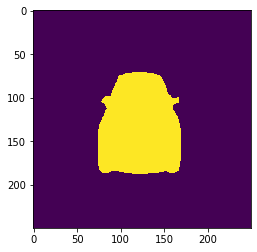

In [161]:
plt.imshow(ale[...,0]>0.5)

In [53]:
np.unique(mask.squeeze().detach().cpu())

array([-22.106203, -22.058504, -21.917168, ...,  14.447593,  14.476112,
        14.504631], dtype=float32)

In [0]:
mas=mask.squeeze(0).permute(1,2,0).detach().cpu().numpy()

In [0]:
np.unique(np.array(mas))

array([-11.903682, -11.778411, -11.55094 , ...,  13.719773,  13.916032,
        14.031653], dtype=float32)

In [0]:
ms=trained_model(x.cuda())['out']

In [0]:
dsa=torch.argmax(mask.squeeze(), dim=0).detach().cpu().numpy()

In [0]:
ms=ms[1,:].permute(1,2,0).detach().cpu().numpy()


In [0]:
np.unique(dsa)

array([0, 7])

TypeError: ignored

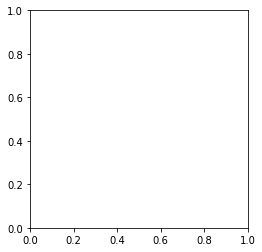

In [38]:
plt.imshow(dsa)

In [0]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

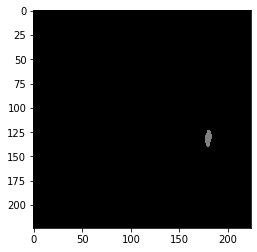

In [0]:
af=decode_segmap(dsa)
plt.imshow(af)

In [0]:
np.unique(af)

array([0], dtype=uint8)

In [0]:
model=load_model().eval()

FileNotFoundError: ignored

In [0]:
def save_model(model):
    torch.save(model, '/content/drive/My Drive/extralaste435.pth')

In [135]:
save_model(model)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DeepLabHead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPPConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ASPPConv2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
